# Replicate results from ChromEMT

In this notebook, we try to reproduce the figures from Ou et al.


In [1]:
import numpy as np
from skimage.io import imread
from matplotlib import pyplot as plt

from chromemt_analysis import segment_like_paper, continuous_erosion_edt, linear_fit_to_residual_volume


## 1) load ChromEMT volume and extract patches like in paper

In [2]:
## 1) Load ChromEMT volume from Fig. 4
chromemt_img = imread('/Volumes/davidh-ssd/chromemt_data/49801.tif')

## Fig. 7 (mitotich chromosome)
# chromemt_img = imread('F:/chromemt_data/49803.tif')

chromemt_img.shape

(121, 1108, 942)

In [3]:
# pixel and tile size (nm)
pixel_size = 1.28
tile_size_nm = 120.0

## number of tiles to cut in zyx
# Fig. 4
n_tiles = (1, 8, 8)

# Fig. 7
# n_tiles = (1, 6, 6)

# tile size in pixel (NOTE: we round up here, paper leaves it unclear how the non-integer patches were cut)
tile_size = int( np.ceil( tile_size_nm / pixel_size ))

# where to start cutting tiles
# NOTE: no information about z in paper (we assume central to mean middle planes), yx guessed according to Fig. 4
tile_offsets = ((chromemt_img.shape[0] - tile_size) // 2 , 150, 50)

# offset for Fig. 7
# tile_offsets = ((chromemt_img.shape[0] - tile_size) // 2 , 310, 130)

cut_starts = np.meshgrid(*(np.arange(tile_offsets_i, tile_offsets_i + n_tiles_i * tile_size, tile_size ) for tile_offsets_i, n_tiles_i in zip(tile_offsets, n_tiles)), indexing='ij')
cut_starts = np.stack(cut_starts, -1)
cut_starts = cut_starts.reshape((np.prod(n_tiles), -1))

### Check cut location

Plot cuts for verification, as exact location is not given in paper

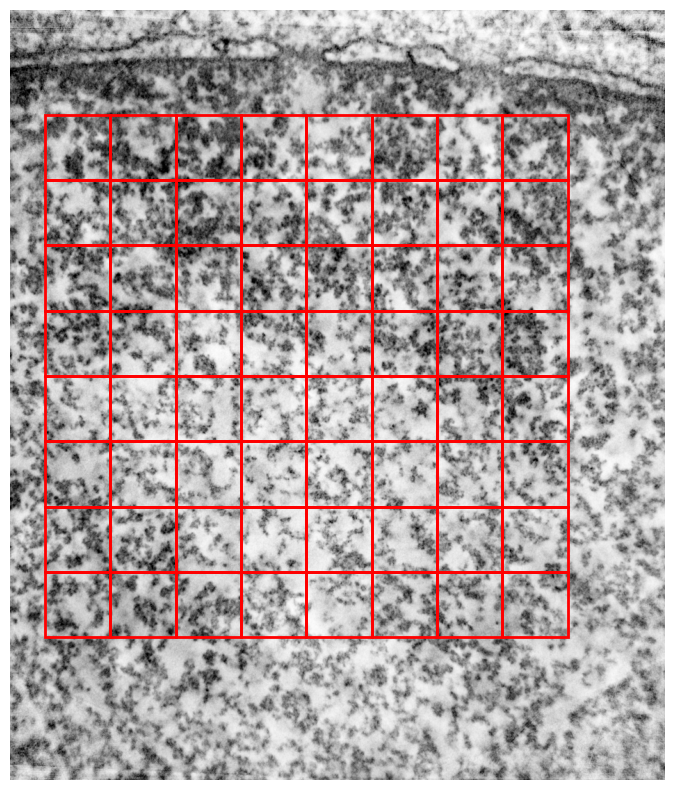

In [4]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(chromemt_img[0], cmap='gray')

for cut_start in cut_starts:
    rec = Rectangle(cut_start[:0:-1], tile_size, tile_size, fill=None, color='red', lw=2)
    ax.add_artist(rec)
    ax.axis('off')

## 2) Segment like paper and calculate CVC

In [5]:
patches = []
masks = []
cvcs = []

import tqdm
from concurrent.futures import ThreadPoolExecutor

## to segment whole image first and then just cut masks, use cut_from_existing_seg instead of cut_and_seg
# mask_whole = segment_like_paper(chromemt_img)
# def cut_from_exisitng_seg(cut_start):
#     patch = chromemt_img[tuple(slice(c, c+tile_size) for c in cut_start)]
#     mask = mask_whole[tuple(slice(c, c+tile_size) for c in cut_start)]
#     return patch, mask

def cut_and_seg(cut_start):
    patch = chromemt_img[tuple(slice(c, c+tile_size) for c in cut_start)]
    mask = segment_like_paper(patch)
    return patch, mask

futures = []
with ThreadPoolExecutor() as tpe:
    for cut_start in cut_starts:
        futures.append(tpe.submit(cut_and_seg, cut_start))

    for f in tqdm.tqdm(futures):
        patch, mask = f.result()
        cvc = mask.sum() / mask.size
        patches.append(patch)
        masks.append(mask)
        cvcs.append(cvc)

100%|██████████| 64/64 [00:15<00:00,  4.01it/s]


## 3) Plots like paper

### 1: CVC for patches heatmap

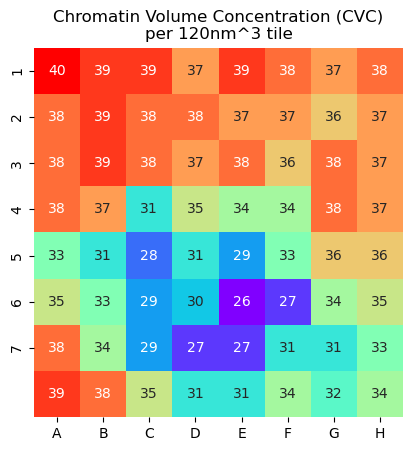

In [6]:
import seaborn as sns

# 'ABC...'
alphabet = ''.join([chr(i) for i in range(ord('A'), ord('A')+26)])

# CVC per tile plot, similar to paper
sns.heatmap(np.reshape(cvcs, n_tiles).squeeze().round(2)*100, annot=True, cmap='rainbow', cbar=False, xticklabels=alphabet[:n_tiles[1]], yticklabels=range(1,n_tiles[1]), square=True)
plt.title('Chromatin Volume Concentration (CVC)\nper 120nm^3 tile');

### 2: chromatin diameter estimation via continuous erosion

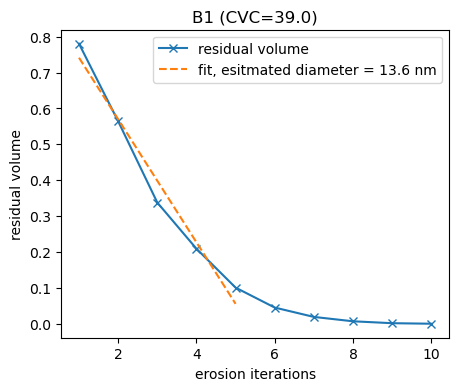

In [41]:
mask_grid = np.reshape(masks, n_tiles + (tile_size,)*3).squeeze()

index_str = 'B1'

mask_cut = mask_grid[int(index_str[1])-1, alphabet.index(index_str[0])]

erosion_radii = np.arange(1, 11)
trace = continuous_erosion_edt(mask_cut, erosion_radii)

d, model = linear_fit_to_residual_volume(trace, erosion_radii, 5)

plt.figure(figsize=(5,4))
plt.plot(erosion_radii, trace, '-x', label='residual volume')
plt.plot(np.arange(1, d // 2 + 1), model.predict(np.arange(1, d // 2 + 1).reshape(-1,1)), '--', label=f'fit, esitmated diameter = {np.round(d*pixel_size, 1)} nm')
plt.title(index_str + f' (CVC={np.round(mask_cut.sum() / mask_cut.size * 100)})')
plt.ylabel('residual volume')
plt.xlabel('erosion iterations')
plt.legend()

In [ ]:
from skimage.io import imsave

tile_grid = np.reshape(patches, n_tiles + (tile_size,)*3).squeeze()
tile_grid.shape

# imsave('F:/chromemt_data/fig4_patch_a1.tif', np.expand_dims(tile_grid[0,0], 1), imagej=True)